In [1]:
from config.config import DB_CONFIG
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine

# Check we have data

In [2]:
connection_string = (
    f"postgresql+psycopg2://{DB_CONFIG['user']}:{DB_CONFIG['password']}"
    f"@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"
)
conn = create_engine(connection_string)

In [3]:
pd.read_sql_query("""
    SELECT *
    FROM countries
""", conn).T

,0,1
id,CR,VN
name,Costa Rica,Vietnam
total_production,86164791,1878000003
num_farmers,32899,615738
num_middlemen,165,1331
num_exporters,31,73
max_buyers_per_farmer,3,3
max_exporters_per_middleman,3,3
farmer_production_sigma,0.8,0.8
middleman_capacity_sigma,0.5,0.5


# Get data for a test country

In [4]:
COUNTRY = 'VN'

In [5]:
df_farmers = pd.read_sql_query(f"""
    SELECT *
    FROM farmers
    WHERE country_id = '{COUNTRY}'
""", conn)
df_farmers.tail()

,id,country_id,geography_id,num_plots,production_amount,loyalty
615733,VN_F_0124919,VN,vn_ssu_dak_rmoan,3,5652.0,0.549125
615734,VN_F_0124920,VN,vn_ssu_dak_rmoan,3,2388.0,0.729724
615735,VN_F_0124921,VN,vn_ssu_dak_rmoan,3,5079.0,0.778300
615736,VN_F_0124922,VN,vn_ssu_dak_rmoan,3,1101.0,0.737140
615737,VN_F_0124923,VN,vn_ssu_dak_rmoan,1,6038.0,0.387937


In [6]:
df_geos = pd.read_sql_query(f"""
    SELECT *
    FROM geographies
    WHERE country_id = '{COUNTRY}'
""", conn)
df_geos.tail()

,id,country_id,name,centroid,producing_area_name,num_farmers,total_production_kg,primary_crop
667,vn_ssu_ya_tang,VN,Ya Tăng,"14.269,107.757",vn_pa_kon_tum,14,48667,robusta
668,vn_ssu_ya_xier,VN,Ya Xiêr,"14.346,107.772",vn_pa_kon_tum,28,86102,robusta
669,vn_ssu_yen_chau,VN,Yên Châu,"20.995,104.329",vn_pa_son_la,469,450794,arabica
670,vn_ssu_yen_do,VN,Yên Đỗ,"13.985,107.991",vn_pa_gia_lai,118,153848,robusta
671,vn_ssu_yen_the_1,VN,Yên Thế,"14.032,107.98",vn_pa_gia_lai,1284,1626330,robusta


In [7]:
df_trade = pd.read_sql_query(f"""
    SELECT *
    FROM trading_flows
    WHERE country_id = '{COUNTRY}'
""", conn)
df_trade.tail()

,year,country_id,farmer_id,middleman_id,exporter_id,sold_to_eu,amount_kg
2647692,0,VN,VN_F_0615736,VN_M_01283,VN_E_00020,False,133
2647693,0,VN,VN_F_0615736,VN_M_01283,VN_E_00016,False,7
2647694,0,VN,VN_F_0615737,VN_M_00512,VN_E_00020,False,68
2647695,0,VN,VN_F_0615737,VN_M_00512,VN_E_00070,True,444
2647696,0,VN,VN_F_0615737,VN_M_00512,VN_E_00016,False,306


# Visualize some of the data

In [8]:
def plot_kde(df, group_col, value_col, title, aggfunc='sum'):
    grouped = df.groupby(group_col)[value_col].agg(aggfunc)
    n = len(grouped)
    stats = {
        "avg (kg)": grouped.mean(),
        "std (kg)": grouped.std(),
        "min (kg)": grouped.min(),
        "median (kg)": grouped.median(),        
        "max (kg)": grouped.max(),
        "total (kg)": grouped.sum(),
    }
    plt.figure(figsize=(10, 3))
    sns.histplot(data=grouped, kde=True, stat="count", fill=True)
    plt.title(f"{title} (n={n:,.0f})")
    plt.xlim(0,)
    plt.xlabel("Values")
    plt.ylabel("")

    stats_text = "\n".join([f"{k}: {v:,.0f}" for k, v in stats.items()])
    plt.annotate(stats_text, xy=(0.95, 0.5), xycoords="axes fraction", ha="right", fontsize=10)
    plt.tight_layout()
    plt.show()

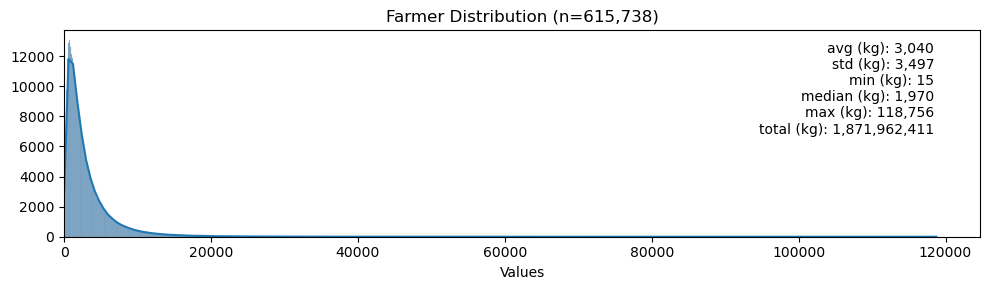

In [9]:
plot_kde(
    df_farmers,
    group_col='id',
    value_col='production_amount',
    title='Farmer Distribution'
)

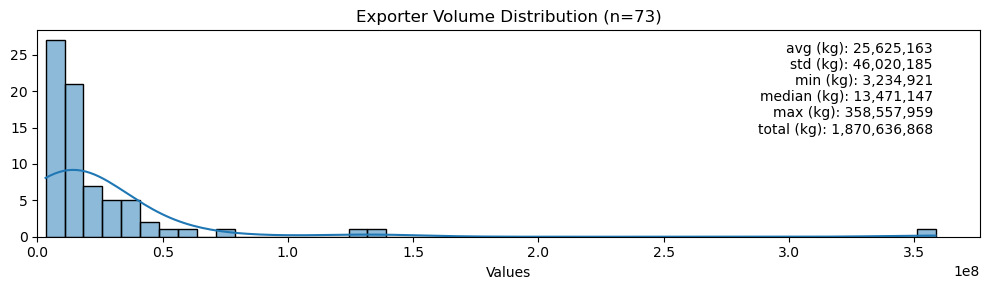

In [10]:
plot_kde(
    df_trade.query("year == 0"),
    group_col='exporter_id',
    value_col='amount_kg',
    title='Exporter Volume Distribution'
)

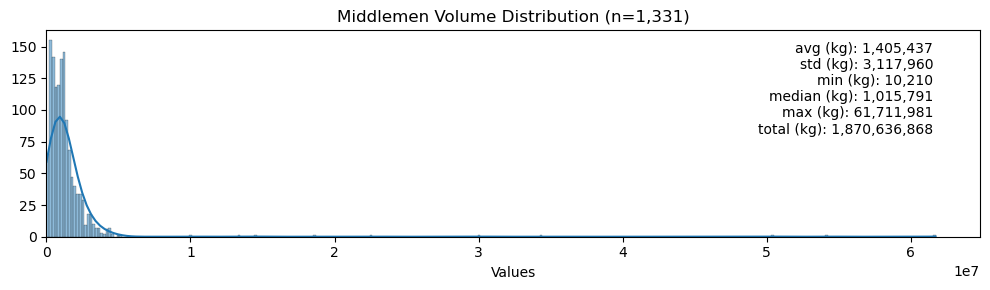

In [11]:
plot_kde(
    df_trade.query("year == 0"),
    group_col='middleman_id',
    value_col='amount_kg',
    title='Middlemen Volume Distribution'
)

<Axes: xlabel='middleman_id', ylabel='exporter_id'>

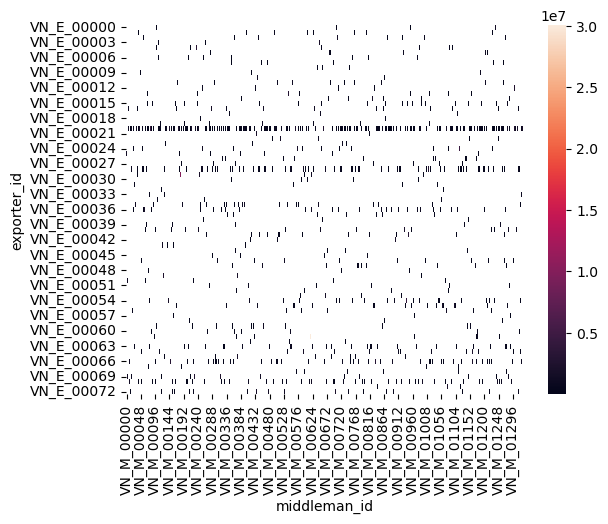

In [12]:
sns.heatmap(df_trade.pivot_table(
    index='exporter_id',
    columns='middleman_id',
    values='amount_kg',
    aggfunc='sum')    
)

In [13]:
df_trade.groupby('farmer_id')['middleman_id'].nunique().value_counts()

middleman_id
2    359413
3    130102
1    126223
Name: count, dtype: int64

# Answer key questions

In [17]:
pd.read_sql_query("""
SELECT 
    country_id,
    year,
    COUNT(DISTINCT farmer_id) as num_farmers,
    SUM(amount_kg) / 60 as eu_sales_in_bags
FROM trading_flows
WHERE sold_to_eu = True
GROUP BY country_id, year;
""", conn)

,country_id,year,num_farmers,eu_sales_in_bags
0,CR,0,15933,219080
1,CR,1,15735,215858
2,CR,2,15739,218090
3,VN,0,471340,10061796


In [18]:
pd.read_sql_query("""
WITH eu_sales AS (
    SELECT
        country_id,
        farmer_id,
        SUM(amount_kg) as eu_sales
    FROM trading_flows
    WHERE sold_to_eu = True
    GROUP BY country_id, farmer_id
)
SELECT
    es.country_id,
    COUNT(DISTINCT es.farmer_id) as num_farmers,
    SUM(f.num_plots) as num_plots
FROM eu_sales es
JOIN farmers f ON es.farmer_id = f.id
GROUP BY es.country_id;
""", conn)

,country_id,num_farmers,num_plots
0,CR,26995,53873
1,VN,471340,942391
